In [ ]:
# import os
# from time import time
# import multiprocessing
# import netCDF4 as nc
# import xarray as xr
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import pandas

In [2]:
# epoch = np.datetime64('1970-01-01T00:00:00')
# T = ((12*60+25)*60)/2 
# T = (12*60+25)*60

In [1]:
# differs from the turning point finding algorithm in trs.py due to the difference in period for power vs elevation
# i.e. step size and T are different
from turningpointsrange import *

In [2]:
ds_range = xr.open_dataset('data/processed/range-pd-sync4.nc')
idx_peaks_troughs = xr.open_dataset('data/processed/range-indices-coarse14.nc')
subset = xr.open_dataset('data/processed/range-coarse-2020-01.nc')
ds_range_mean = xr.open_dataset('data/processed/range-mean-power3.nc')


In [3]:
pd = ds_range.pd.values
p_mean = ds_range_mean.power.values

t = ds_range.time.values # these aren't the same time values to be indexing, at least not for high water
latitude = ds_range.lat.values
longitude = ds_range.lon.values

# t = subset.time.values # time values for low/high water, not power
# first_peak = idx_peaks_troughs.peak.values[0,:,:] # phase of high water not directly of power
# first_trough = idx_peaks_troughs.trough.values[0,:,:]

In [7]:
idx_peaks,_,__ = peak_trough_idx(pd,t,latitude,longitude) 

In [8]:
idx_peaks.shape

(108, 519, 232)

In [9]:
first_peak = idx_peaks[0,:,:]

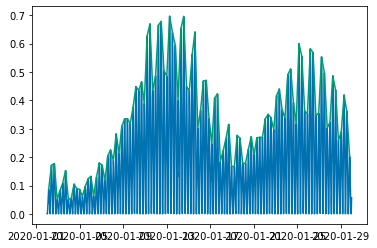

In [10]:
test = idx_peaks[:,500,20][idx_peaks[:,500,20]<=len(t)].astype('int')
plt.figure()
plt.plot(t,pd[:,500,20])
plt.plot(t[test],pd[test,500,20])

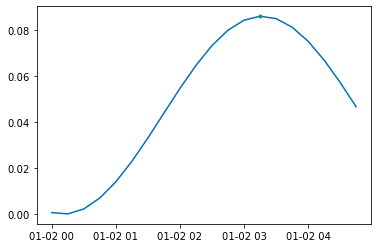

In [19]:
test1 = int(first_peak[500,20])
plt.figure()
plt.plot(t[:20],pd[:20,500,20])
plt.plot(t[test1],pd[test1,500,20],'.')

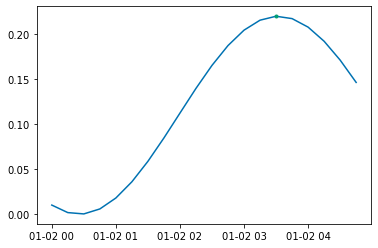

In [22]:
test2 = int(first_peak[400,30])
plt.figure()
plt.plot(t[:20],pd[:20,400,30])
plt.plot(t[test2],pd[test2,400,30],'.')

In [8]:
secs = (t-epoch)/1e9 # dtype is timedelta[s] not timedelta[ns]
secs = secs.astype('float64')
secs = secs - secs[0]
phase = (secs/T)*2*np.pi
phase = phase%(2*np.pi)

In [9]:
phase_peak = np.zeros((len(ds_range.lat.values),len(ds_range.lon.values)))
phase_peak[:] = np.nan

for j in range(len(ds_range.lat.values)):
    for k in range(len(ds_range.lon.values)):
        if np.isnan(first_peak[j,k]) == True:
            pass
        else: 
            phase_peak[j,k] = phase[int(first_peak[j,k])]
            
    

In [10]:
phase_peak.shape

(519, 232)

In [11]:
phase_xr = xr.Dataset({
    'phase': xr.DataArray(
        data=phase_peak,
        coords={'lat': ds_range.lat.values,
                'lon': ds_range.lon.values},
        dims=['lat','lon'])})


phase_xr['phase'] = phase_xr.phase.assign_attrs(units='radians')
phase_xr['phase'] = phase_xr.phase.assign_attrs(long_name='power phase difference relative to 2020-01-02T00:00:00')
phase_xr['lat'] = phase_xr.lat.assign_attrs(units='degrees')
phase_xr['lat'] = phase_xr.lat.assign_attrs(long_name='latitude')
phase_xr['lon'] = phase_xr.lon.assign_attrs(units='degrees')
phase_xr['lon'] = phase_xr.lon.assign_attrs(long_name='longitude')

phase_xr.to_netcdf(path=f'data/processed/range-static-powerphase.nc')

In [5]:
ds = xr.open_dataset('data/processed/range-static-powerphase.nc')

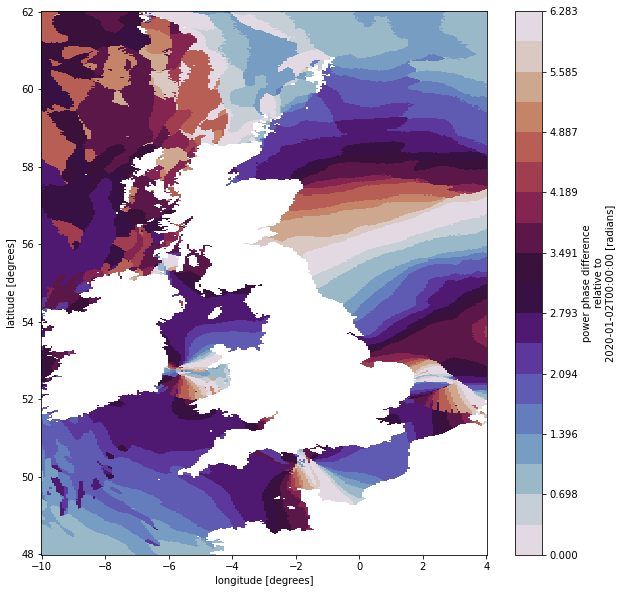

In [6]:
cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_bad('white')

ds.phase.plot(size=10,aspect=1,levels=19,vmin=0,vmax=2*np.pi,cmap=cmap)  

# plt.savefig('figures/for-report/range-phase-map.png')

In [8]:
search = xr.open_dataset('data/processed/range-search-space.nc')

In [9]:
space = search.space.values

In [10]:
phase_space = np.zeros((len(ds_range.lat.values),len(ds_range.lon.values)))
phase_space[:] = np.nan

for j in range(len(ds_range.lat.values)):
    for k in range(len(ds_range.lon.values)):
        if np.isnan(space[j,k]) == True:
            pass
        elif space[j,k] == 0:
            phase_space[j,k] = -10
        else: 
            phase_space[j,k] = ds.phase.values[j,k]
            
    

In [11]:
phase_xr = xr.Dataset({
    'phase': xr.DataArray(
        data=phase_space,
        coords={'lat': ds_range.lat.values,
                'lon': ds_range.lon.values},
        dims=['lat','lon'])})


phase_xr['phase'] = phase_xr.phase.assign_attrs(units='radians')
phase_xr['phase'] = phase_xr.phase.assign_attrs(long_name='phase difference relative to 2020-01-02T00:00:00')
phase_xr['lat'] = phase_xr.lat.assign_attrs(units='degrees')
phase_xr['lat'] = phase_xr.lat.assign_attrs(long_name='latitude')
phase_xr['lon'] = phase_xr.lon.assign_attrs(units='degrees')
phase_xr['lon'] = phase_xr.lon.assign_attrs(long_name='longitude')

phase_xr.to_netcdf(path=f'data/processed/range-static-powerphase-space1.nc')

In [12]:
ds = xr.open_dataset('data/processed/range-static-powerphase-space-1e7.nc')

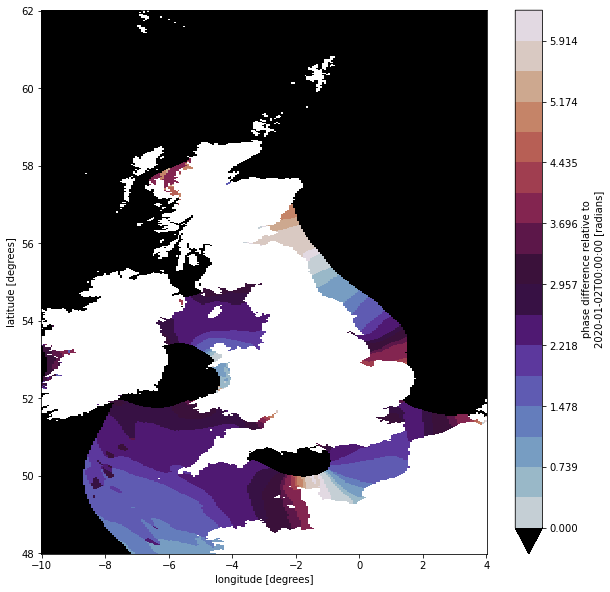

In [13]:
cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_under('black')

ds.phase.plot(size=10,aspect=1,levels=18,vmin=0,vmax=2*np.pi,cmap=cmap)  

In [4]:
ds_high = xr.open_dataset('data/processed/range-static-highphase.nc')

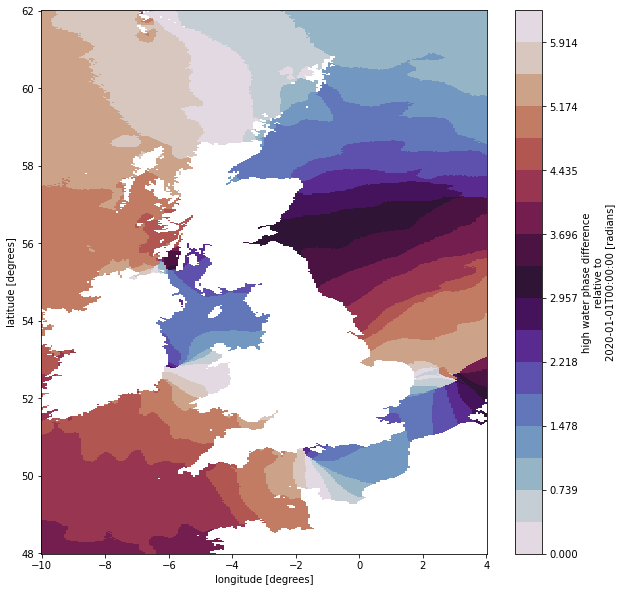

In [5]:
cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_bad('white')
# boundary = [0,np.pi/8,np.pi/4,3*np.pi/8,

ds_high.phase.plot(size=10,aspect=1,levels=18,vmin=0,vmax=2*np.pi,cmap=cmap)  

In [6]:
ds_low = xr.open_dataset('data/processed/range-static-lowphase.nc')

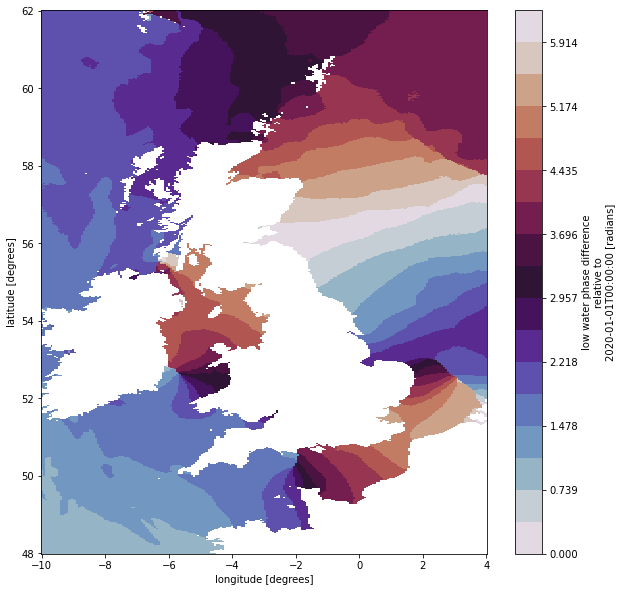

In [7]:
cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_bad('white')

ds_low.phase.plot(size=10,aspect=1,levels=18,vmin=0,vmax=2*np.pi,cmap=cmap)  

In [10]:
mix = np.zeros((len(ds_range.lat.values),len(ds_range.lon.values)))
mix[:] = np.nan

first_peak = ds_high.phase.values
first_trough = ds_low.phase.values

for j in range(len(ds_range.lat.values)):
    for k in range(len(ds_range.lon.values)):
        if np.isnan(first_peak[j,k]) == True:
            pass
        else: 
            if first_peak[j,k]<first_trough[j,k]:
                mix[j,k] = first_peak[j,k]
            elif first_peak[j,k]>first_trough[j,k]:
                mix[j,k] = first_trough[j,k]
                
    

In [2]:
ds = xr.open_dataset('data/processed/range-static-highlowphase.nc')

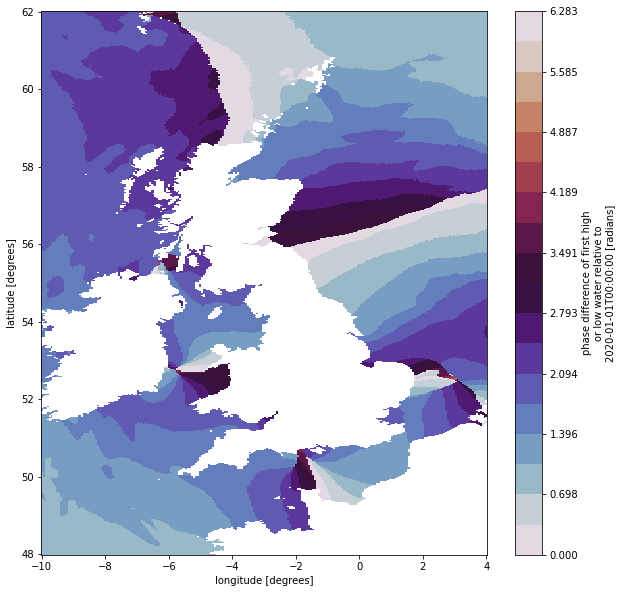

In [4]:
ds['phase'] = ds.phase.assign_attrs(long_name='phase difference of first high or low water relative to 2020-01-01T00:00:00')


cmap = mpl.cm.get_cmap('twilight').copy()
cmap.set_bad('white')

ds.phase.plot(size=10,aspect=1,levels=19,vmin=0,vmax=2*np.pi,cmap=cmap)  

# plt.savefig('figures/for-report/highlow-phase-map.png')

In [ ]:
### map of mean power

In [14]:
search = xr.open_dataset('data/processed/range-search-space-1e7.nc')
space = search.space.values

In [15]:
power_space = np.zeros((len(ds_range.lat.values),len(ds_range.lon.values)))
power_space[:] = np.nan

for j in range(len(ds_range.lat.values)):
    for k in range(len(ds_range.lon.values)):
        if np.isnan(space[j,k]) == True:
            pass
        elif space[j,k] == 0:
            power_space[j,k] = -10
        else: 
            power_space[j,k] = p_mean[j,k]

In [16]:
pow_xr = xr.Dataset({
    'power': xr.DataArray(
        data=power_space,
        coords={'lat': ds_range.lat.values,
                'lon': ds_range.lon.values},
        dims=['lat','lon'])})


pow_xr['power'] = pow_xr.power.assign_attrs(units='W')
pow_xr['power'] = pow_xr.power.assign_attrs(long_name='mean power')
pow_xr['lat'] = pow_xr.lat.assign_attrs(units='degrees')
pow_xr['lat'] = pow_xr.lat.assign_attrs(long_name='latitude')
pow_xr['lon'] = pow_xr.lon.assign_attrs(units='degrees')
pow_xr['lon'] = pow_xr.lon.assign_attrs(long_name='longitude')

pow_xr.to_netcdf(path=f'data/processed/range-static-meanpow-space-1e7.nc')

In [17]:
ds = xr.open_dataset('data/processed/range-static-meanpow-space-1e7.nc')

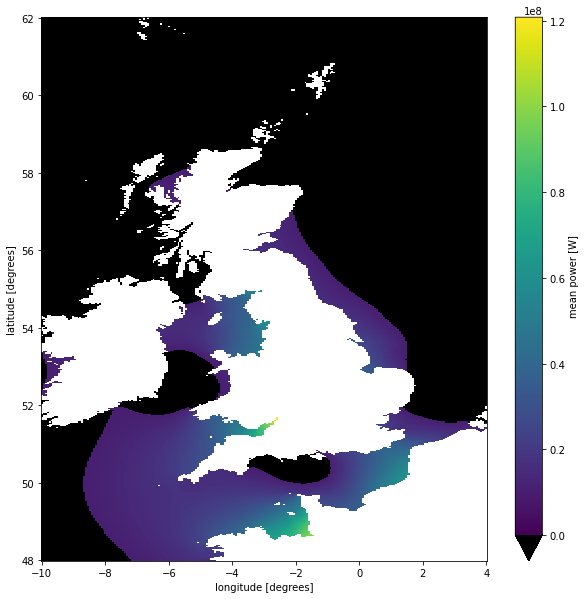

In [18]:
cmap = mpl.cm.get_cmap('viridis').copy()
cmap.set_under('black')

ds.power.plot(size=10,aspect=1,vmin=0,cmap=cmap)  